In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

random.seed(1000)

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

/var/folders/lh/98dp9hg53bjb8v17_1dc51k00000gn/T/ipykernel_2161/3159236473.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Side to side comparison plots

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [5]:
train_df = pd.read_csv('JORN21_dataset_v1.csv', na_values='?').dropna()
test_df = pd.read_csv('JORN17_dataset_v1.csv', na_values='?').dropna()
train_df
test_df

,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,Veg_class
0,2,2,2,16.0,4.79,0.010000,0.223962,0.226896,0.239161,0.273236,0.274394,0.307885,0.402131,0.406066,0.427636,0.278782,0.280285,0.316995,woody
1,3,3,3,8.6,2.24,0.010000,0.287822,0.287822,0.316384,0.302193,0.302193,0.305906,0.448325,0.448325,0.469259,0.301407,0.301407,0.304224,woody
2,4,4,4,27.8,11.12,0.012500,0.289236,0.313074,0.459671,0.300200,0.318621,0.374641,0.447470,0.466219,0.570786,0.298798,0.314429,0.358302,woody
3,5,5,5,24.2,10.62,0.060000,0.330255,0.375986,0.498250,0.313174,0.335601,0.386369,0.477596,0.517136,0.598966,0.309534,0.325886,0.368766,woody
4,6,6,6,17.4,6.10,0.012000,0.275800,0.341526,0.416294,0.264112,0.280268,0.314841,0.431575,0.487791,0.518614,0.266352,0.273629,0.312146,woody
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2696,2698,2698,2698,16.0,3.12,0.005000,0.085548,0.085548,0.098842,0.207851,0.207851,0.216101,0.296033,0.296033,0.306464,0.222759,0.222759,0.230124,woody
2697,2699,2699,2699,12.0,3.45,0.020000,0.061574,0.056132,0.076203,0.196788,0.198325,0.200353,0.276355,0.274378,0.285173,0.212724,0.214114,0.215713,non-woody
2698,2700,2700,2700,14.0,4.95,0.011429,0.195101,0.181629,0.466077,0.263570,0.256796,0.378514,0.374646,0.365065,0.561462,0.267252,0.261795,0.353228,woody
2699,2701,2701,2701,24.4,8.00,0.012857,0.153912,0.123123,0.369357,0.236553,0.228040,0.354934,0.336482,0.324982,0.496476,0.240477,0.235988,0.336204,non-woody


In [6]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

testindex8 = []
testindex9 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

    testindex8.append(test_index)
    testindex9.append(pred_values)
    
elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.04275889600000049 seconds ---

Accuracy of each fold: 
 [0.675990675990676, 0.6915887850467289, 0.7383177570093458, 0.7429906542056075, 0.7079439252336449]
Avg accuracy: 0.7113663594972006
Std of accuracy : 
0.02600299342248098

[[ 314  149]
 [ 469 1209]]

              precision    recall  f1-score   support

   non-woody       0.40      0.68      0.50       463
       woody       0.89      0.72      0.80      1678

    accuracy                           0.71      2141
   macro avg       0.65      0.70      0.65      2141
weighted avg       0.78      0.71      0.73      2141

0.6781857451403888
0.7205005959475567
0.40102171136653897
0.5040128410914929


In [7]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed = woodyarea1/totalarea1 * 100
print(needed)

---Run time is 0.12989176099999966 seconds ---
36.82997357167485


In [8]:
woodyarea4 = 0
nonwoodyarea4 = 0
totalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(0,5):
            for l in testindex9[k]:
                if l == "woody":
                    woodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC4 = woodyarea4/totalarea4 * 100
                    
print(FWC4)

---Run time is 123.76367450599999 seconds ---
63.428304530654536


In [9]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex1 = []
testindex2 = []
for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex1.append(test_index)
    testindex2.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 123.83376173399999 seconds ---

Accuracy of each fold: 
 [0.662004662004662, 0.6939252336448598, 0.7102803738317757, 0.735981308411215, 0.7102803738317757]
Avg accuracy: 0.7024943903448577
Std of accuracy : 
0.024312405503824627

[[ 298  165]
 [ 472 1206]]

              precision    recall  f1-score   support

   non-woody       0.39      0.64      0.48       463
       woody       0.88      0.72      0.79      1678

    accuracy                           0.70      2141
   macro avg       0.63      0.68      0.64      2141
weighted avg       0.77      0.70      0.72      2141

0.6436285097192225
0.7187127532777116
0.38701298701298703
0.4833738848337389


In [10]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
print(woodyarea1/totalarea1 * 100)

needed2 = woodyarea1/totalarea1 * 100
print(needed2)

---Run time is 0.15452340799998865 seconds ---
36.82997357167485
36.82997357167485


In [11]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(0,5):
            for l in testindex2[k]:
                if l == "woody":
                    woodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC = woodyarea1/totalarea1 * 100
                    
print(FWC)

---Run time is 130.92461150000003 seconds ---
64.03549743118107


In [12]:
print(woodyarea1)
print(nonwoodyarea1)
print(totalarea1)

54220911.24005378
30452298.79997503
84673210.03998598


In [13]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex3 = []
testindex4 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    #makes the list for FWC
    testindex3.append(test_index)
    testindex4.append(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 130.98513483200003 seconds ---

Accuracy of each fold: 
 [0.634032634032634, 0.6425233644859814, 0.6308411214953271, 0.6518691588785047, 0.6355140186915887]
Avg accuracy: 0.6389560595168072
Std of accuracy : 
0.007502183448854171

[[381  82]
 [691 987]]

              precision    recall  f1-score   support

   non-woody       0.36      0.82      0.50       463
       woody       0.92      0.59      0.72      1678

    accuracy                           0.64      2141
   macro avg       0.64      0.71      0.61      2141
weighted avg       0.80      0.64      0.67      2141

0.8228941684665226
0.5882002383790227
0.355410447761194
0.4964169381107492


In [14]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed3 = woodyarea1/totalarea1 * 100
print(needed3)

---Run time is 0.14876722100001416 seconds ---
36.82997357167485


In [15]:
woodyarea2 = 0
nonwoodyarea2 = 0
totalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(0,5):
            for l in testindex4[k]:
                if l == "woody":
                    woodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC2 = woodyarea2/totalarea2 * 100
                    
print(FWC2)

---Run time is 129.57780483599998 seconds ---
49.92993928066854


In [16]:
print(woodyarea2)
print(nonwoodyarea2)
print(totalarea2)
print(FWC2)

42277282.35995794
42395927.67995784
84673210.03998598
49.92993928066854


#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [17]:
KNN_result = []
X=train_df.iloc[:, 5:18]
Y=train_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.77855478 0.78271028 0.78037383 0.77336449 0.8271028 ]

Avg accuracy: 0.7884212360847874

K=2

Accuracy of each fold: 
 [0.78088578 0.75700935 0.76635514 0.7546729  0.78271028]

Avg accuracy: 0.7683266888874364

K=3

Accuracy of each fold: 
 [0.81818182 0.81542056 0.81074766 0.79672897 0.84345794]

Avg accuracy: 0.8169073916737469

K=4

Accuracy of each fold: 
 [0.80885781 0.79672897 0.80140187 0.78504673 0.83878505]

Avg accuracy: 0.8061640851360478

K=5

Accuracy of each fold: 
 [0.82051282 0.8364486  0.81308411 0.81542056 0.84813084]

Avg accuracy: 0.8267193865324705

K=6

Accuracy of each fold: 
 [0.81118881 0.8364486  0.80841121 0.79205607 0.84813084]

Avg accuracy: 0.8192471080321548

K=7

Accuracy of each fold: 
 [0.81585082 0.85981308 0.81775701 0.82009346 0.83878505]

Avg accuracy: 0.8304598827963314

K=8

Accuracy of each fold: 
 [0.81351981 0.85514019 0.81074766 0.80607477 0.84345794]

Avg accuracy: 0.8257880748534955

K=9

Accuracy of each fo

In [18]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=9)

acc_score = []
Truth = []
Output = []

testindex5 = []
testindex6 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex5.append(test_index)
    testindex6.append(pred_values)


elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 130.75370680600003 seconds ---

Accuracy of each fold: 
 [0.675990675990676, 0.6892523364485982, 0.7102803738317757, 0.7149532710280374, 0.7102803738317757]
Avg accuracy: 0.7001514062261726
Std of accuracy : 
0.015012113633011668

[[ 334  129]
 [ 513 1165]]

              precision    recall  f1-score   support

   non-woody       0.39      0.72      0.51       463
       woody       0.90      0.69      0.78      1678

    accuracy                           0.70      2141
   macro avg       0.65      0.71      0.65      2141
weighted avg       0.79      0.70      0.72      2141

0.7213822894168467
0.6942789034564958
0.39433293978748524
0.5099236641221374


In [19]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed4 = woodyarea1/totalarea1 * 100
print(needed4)

---Run time is 0.1206167539999683 seconds ---
36.82997357167485


In [20]:
woodyarea3 = 0
nonwoodyarea3 = 0
totalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(0,5):
            for l in testindex6[k]:
                if l == "woody":
                    woodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC3 = woodyarea3/totalarea3 * 100
                    
print(FWC3)

---Run time is 128.98445754099998 seconds ---
60.43904717428209


In [21]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.711366,0.026003,0.678186,0.720501,0.401022,0.504013,0.042759
LDA,0.702494,0.024312,0.643629,0.718713,0.387013,0.483374,123.833762
QDA,0.638956,0.007502,0.822894,0.588200,0.355410,0.496417,130.985135
KNN-CV,0.700151,0.015012,0.721382,0.694279,0.394333,0.509924,130.753707


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.7113663594972006, 0.7024943903448577, 0.6389560595168072, 0.7001514062261726]
Sen[0.6781857451403888, 0.6436285097192225, 0.8228941684665226, 0.7213822894168467]
Spec[0.7205005959475567, 0.7187127532777116, 0.5882002383790227, 0.6942789034564958]
P[0.40102171136653897, 0.38701298701298703, 0.355410447761194, 0.39433293978748524]
F1[0.5040128410914929, 0.4833738848337389, 0.4964169381107492, 0.5099236641221374]


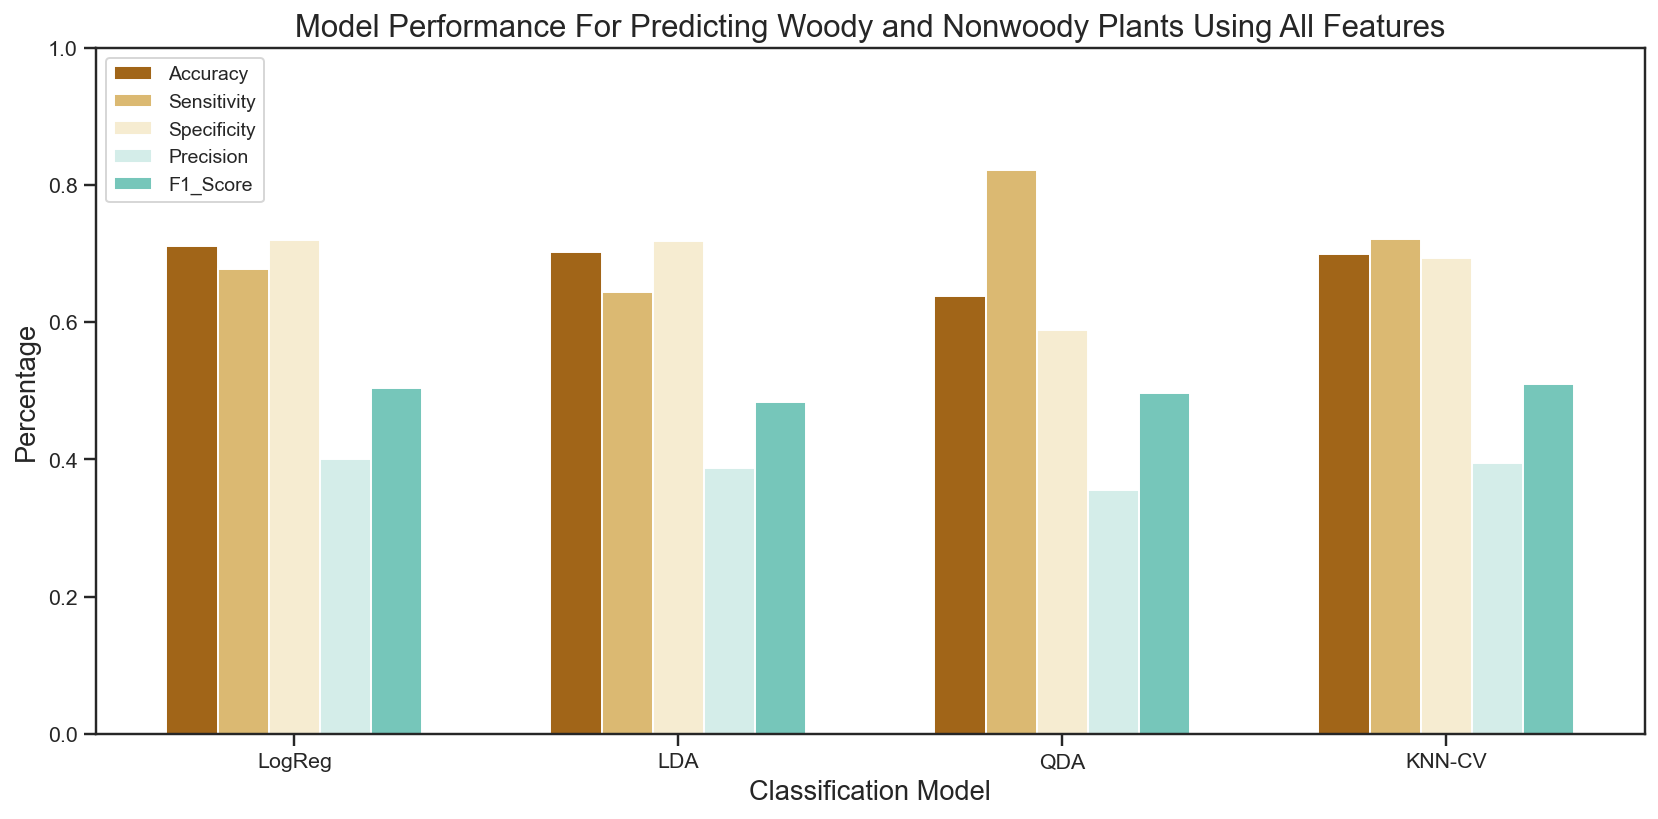

In [22]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

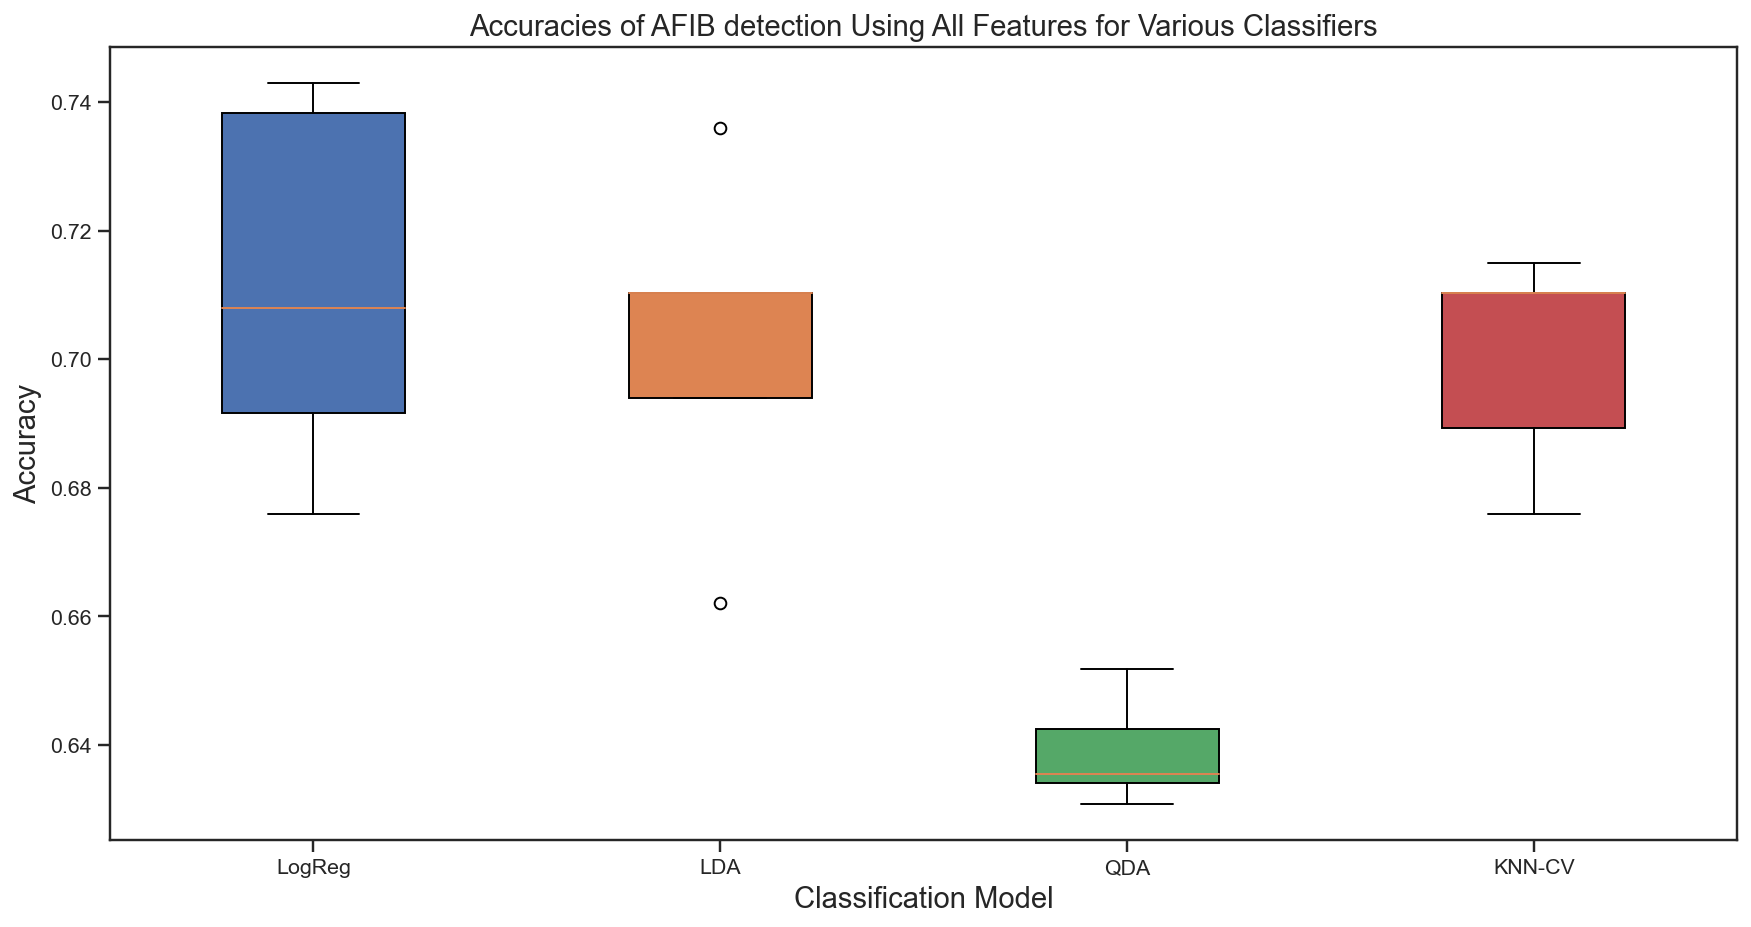

In [23]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()

In [24]:
print("Log reg act: " + str(needed))
print("Log reg pred: " + str(FWC4))
print("QDA act: " + str(needed2))
print("QDA pred: " + str(FWC2))
print("LDA act: " + str(needed3))
print("LDA pred: " + str(FWC))
print("KNN act: " + str(needed4))
print("KNN pred: " +str(FWC3))

Log reg act: 36.82997357167485
Log reg pred: 63.428304530654536
QDA act: 36.82997357167485
QDA pred: 49.92993928066854
LDA act: 36.82997357167485
LDA pred: 64.03549743118107
KNN act: 36.82997357167485
KNN pred: 60.43904717428209


In [25]:
Logerrorrate = abs((needed-FWC4)/needed) *100
QDAerrorrate = abs((needed-FWC2)/needed) *100
LDAerrorrate = abs((needed-FWC)/needed) *100
KNNerrorrate = abs((needed-FWC3)/needed) *100

In [26]:
print("log ER = " + str(Logerrorrate))
print("QDA ER = " + str(QDAerrorrate))
print("LDA ER = " + str(LDAerrorrate))
print("KNN ER = " + str(KNNerrorrate))

log ER = 72.21925073396169
QDA ER = 35.56876217545972
LDA ER = 73.86788862761881
KNN ER = 64.10287956536705
